In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.AnalysisStorage("_toy_retis.nc")

In [2]:
retis = storage.transitions.load(0)
retis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [3]:
%%time
retis.rate(storage)

CPU times: user 1.29 s, sys: 178 ms, total: 1.47 s
Wall time: 1.47 s


0.011239053819296923

In [4]:
%%time
print retis.conditional_transition_probability(storage, retis.ensembles[-1])

0.940298507463
CPU times: user 8.04 ms, sys: 2.5 ms, total: 10.5 ms
Wall time: 8.92 ms


In [5]:
retis.all_statistics(storage, force=True)

In [6]:
retis.total_crossing_probability(storage=storage)

In [7]:
print retis.minus_move_flux(storage=storage)

0.0555555555556


In [8]:
%%time
scheme = paths.MoveScheme(retis)
scheme.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 5 ran 12.9353233831% of the cycles with acceptance 20/26 (0.769230769231) 
OneWayShootingMover I'face 1 ran 6.46766169154% of the cycles with acceptance 11/13 (0.846153846154) 
OneWayShootingMover I'face 0 ran 8.9552238806% of the cycles with acceptance 18/18 (1.0) 
OneWayShootingMover I'face 2 ran 7.46268656716% of the cycles with acceptance 12/15 (0.8) 
OneWayShootingMover I'face 3 ran 9.45273631841% of the cycles with acceptance 16/19 (0.842105263158) 
OneWayShootingMover I'face 4 ran 5.97014925373% of the cycles with acceptance 7/12 (0.583333333333) 

CPU times: user 30.9 ms, sys: 9.52 ms, total: 40.4 ms
Wall time: 33.8 ms


In [9]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover I'face 5 ran 12.9353233831% of the cycles with acceptance 20/26 (0.769230769231) 
OneWayShootingMover I'face 1 ran 6.46766169154% of the cycles with acceptance 11/13 (0.846153846154) 
OneWayShootingMover I'face 0 ran 8.9552238806% of the cycles with acceptance 18/18 (1.0) 
OneWayShootingMover I'face 2 ran 7.46268656716% of the cycles with acceptance 12/15 (0.8) 
OneWayShootingMover I'face 3 ran 9.45273631841% of the cycles with acceptance 16/19 (0.842105263158) 
OneWayShootingMover I'face 4 ran 5.97014925373% of the cycles with acceptance 7/12 (0.583333333333) 


In [10]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [11]:
first40 = first_n(storage, 40, trajid=4)

In [12]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 2.54 s, sys: 411 ms, total: 2.95 s
Wall time: 2.98 s


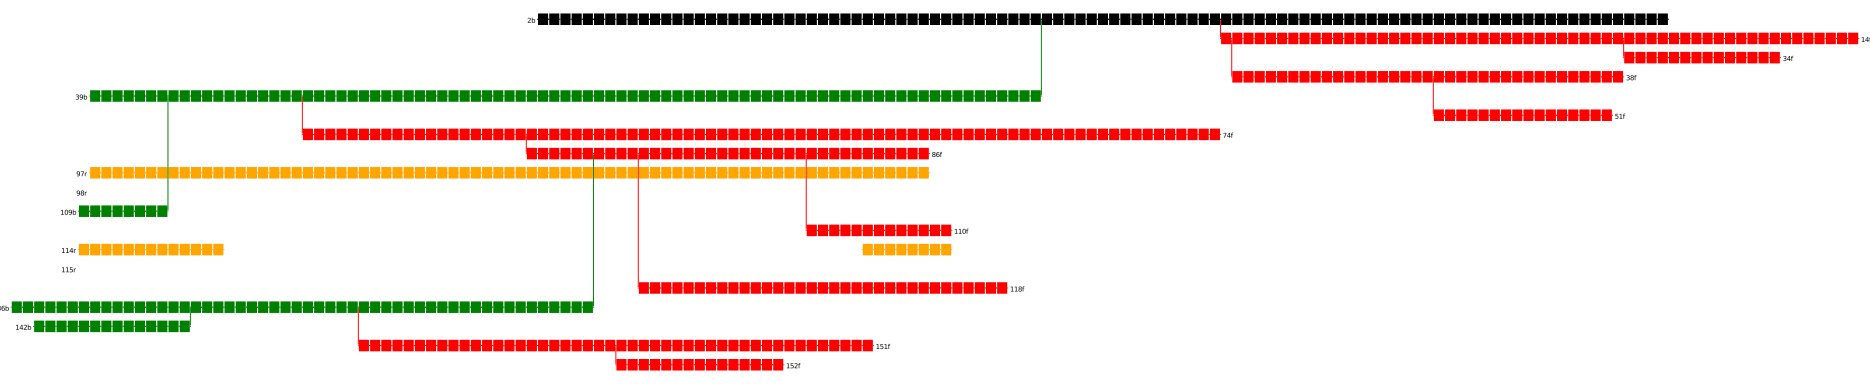

In [13]:
SVG(view.to_svg())

In [14]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 3 decorrelated trajectories.


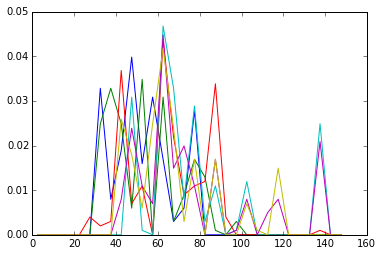

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    normalized = myhist.normalized()
    plt.plot(normalized.x, normalized)

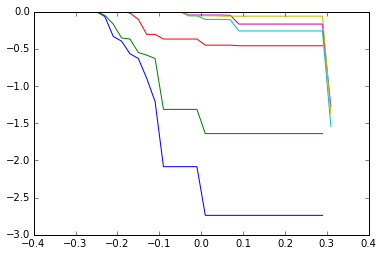

In [16]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    reverse_cumulative = myhist.reverse_cumulative()
    plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))


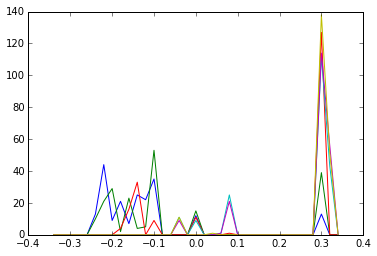

In [17]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]()
    plt.plot(myhist.x, myhist)

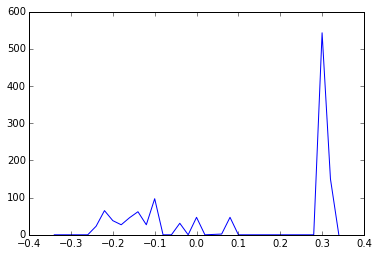

In [18]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.x, total_sampling);

In [19]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

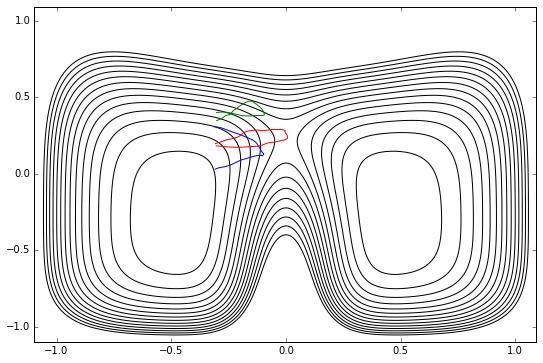

In [20]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

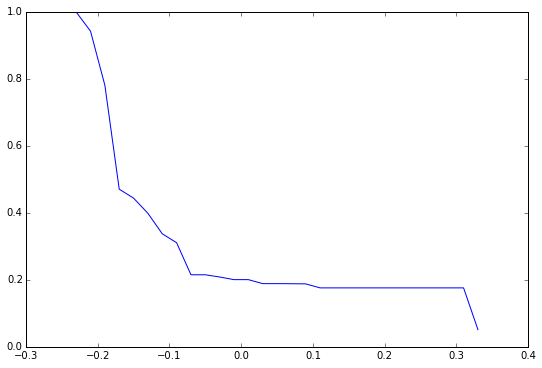

In [21]:
wham = retis.total_crossing_probability(method="wham")
plt.plot(wham.x, wham);

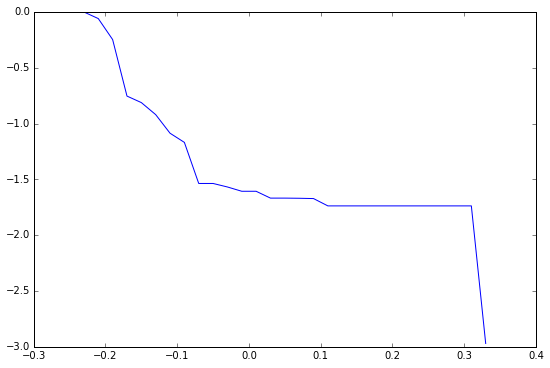

In [22]:
plt.plot(wham.x, np.log(wham));

In [23]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 8.41 ms, sys: 2.66 ms, total: 11.1 ms
Wall time: 9.25 ms


0.9402985074626866

In [24]:
retis.minus_move_flux(storage)

0.055555555555555552

In [25]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.0555555555556 0.215147601684 0.940298507463


In [26]:
retis.rate(storage)

0.011239053819296923

Note that, with insufficient data, the guess for the location of the outermost interface can be incorrect. If you specify the `outer_lambda`, you'll get a different answer.

In [27]:
retis.rate(storage, outer_lambda=-0.05)

0.011239053819296923

In [28]:
print retis._flux * retis.tcp(-0.05) * retis.ctp[retis.ensembles[-1]]

0.0112390538193
